# Sentiment analysis on the IMDB dataset <a name="2"></a>
<hr>


### CountVectorizer with Logistic Regression 

In [91]:
# Import libraries
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve,
    confusion_matrix,
    precision_score,
    recall_score,
)

### Classify the reviews to two categroies: Positive and Negative -> Binary Classification

In [95]:
imdb_df = pd.read_csv("imdb_master.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
imdb_df = imdb_df.query('label == "neg" | label == "pos"')
train_df = imdb_df.query('type == "train"')
test_df = imdb_df.query('type == "test"')

In [96]:
X_train, y_train = train_df["review"], train_df["label"]
X_test, y_test = test_df["review"], test_df["label"]

In [97]:
train_pos = train_df.query('label == "pos"')
train_neg = train_df.query('label == "neg"')

In [98]:
test_pos = test_df.query('label == "pos"')
test_neg = test_df.query('label == "neg"')

In [99]:
y_train = y_train.replace(["neg", "pos"], [0, 1])
y_test = y_test.replace(["neg", "pos"], [0, 1])

### EDA
<hr>

In [100]:
print(f"Training set has {train_pos.shape[0]} positive reviews")
print(f"Training set has {train_neg.shape[0]} negative reviews")

Training set has 12500 positive reviews
Training set has 12500 negative reviews


In [101]:
print(f"Test set has {test_pos.shape[0]} positive reviews")
print(f"Test set has {test_neg.shape[0]} negative reviews")

Test set has 12500 positive reviews
Test set has 12500 negative reviews


Text(0.5, 1.0, 'Positive reviews length')

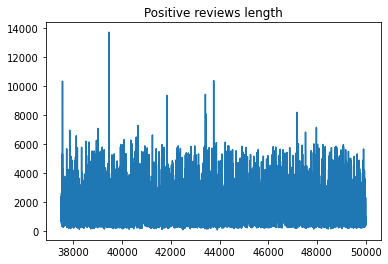

In [102]:
pos_length = train_pos['review'].str.len().plot()
plt.title("Positive reviews length")

Text(0.5, 1.0, 'Negative reviews length')

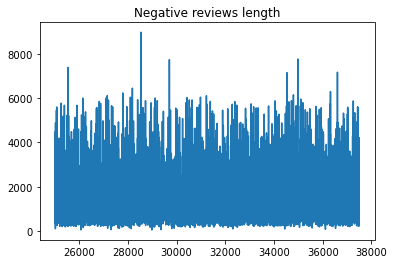

In [103]:
pos_length = train_neg['review'].str.len().plot()
plt.title("Negative reviews length")

In [104]:
print(f"The average length of positive reviews is {train_pos['review'].str.len().mean()}")
print(f"The average length of negative reviews is {train_neg['review'].str.len().mean()}")

The average length of positive reviews is 1347.42648
The average length of negative reviews is 1303.19936


Negative reviews seem a bit shorter on average compared to the positive reviews. But the histograms showing distribution of lengths do not look much different. 

## Model building and hyperparameter optimization
<hr>

Explore a number of models on the dataset and carry out hyperparameter optimization for the logistic regression model. 
Will be using a `store_cross_val_results` function to keep results organized.  

In [105]:
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_valid_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_valid_score": "{:0.4f}".format(scores["test_score"].std()),
    }

### DummyClassifier (Baseline Model)

In [106]:
results_dict = {}
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, n_jobs=-1, return_train_score=True)
store_cross_val_results("Dummy", scores, results_dict)
pd.DataFrame(results_dict).T

,mean_fit_time (s),mean_score_time (s),mean_train_accuracy,mean_valid_accuracy,std_train_score,std_valid_score
Dummy,0.0041,0.0010,0.5010,0.5017,0.0036,0.0025


### CountVectorizer with different models

In [27]:
from sklearn.ensemble import RandomForestClassifier
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "RBF SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators = 100) 
}

In [38]:
for model_name, model in models.items():
    pipe = make_pipeline(CountVectorizer(), model)
    scores = cross_validate(pipe, X_train, y_train, return_train_score=True, n_jobs=-1)
    store_cross_val_results(model_name, scores, results_dict)

pd.DataFrame(results_dict).T

,mean_train_accuracy,mean_valid_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_valid_score
Dummy,0.5003,0.5020,0.0112,0.0092,0.0031,0.0053
Decision Tree,1.0000,0.7080,24.2659,0.7921,0.0000,0.0051
RBF SVM,0.9166,0.8509,492.4621,101.2514,0.0013,0.0036
Naive Bayes,0.9091,0.7788,2.9081,0.7770,0.0045,0.0113
Logistic Regression,0.9991,0.8406,24.9361,0.9380,0.0001,0.0119
Random Forest,1.0000,0.8401,64.2636,1.5807,0.0000,0.0044


1. All models are performing better than the DummyClassifier. 

2. Decision tree and Naive Bayes seem to be suffering from overfitting. 

3. The RandomForest model is fitting alright but it's the slowest.

## Hyperparameter optimization and BagOfWords
<hr>

In [28]:
pipe_lr = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000))
pipe_lr.fit(X_train, y_train)
vocab_size = len(pipe_lr["countvectorizer"].get_feature_names())  # get the vocab_size for
print("Vocab size: ", vocab_size)

Vocab size:  75532


In [29]:
from scipy.stats import lognorm, loguniform, randint

# pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000))
param_grid = {
    "logisticregression__C": loguniform(1e-3, 1e3),
    "countvectorizer__max_features": randint(100, vocab_size),
}

In [31]:
random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=30,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.1min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa3f18697d0>,
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa3f1869290>},
                   random_state=123, return_train_score=True, verbose=1)

In [32]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "param_countvectorizer__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

Best hyperparameter values:  {'countvectorizer__max_features': 73621, 'logisticregression__C': 0.012443724365791027}
Best score: 0.865


,mean_train_score,mean_test_score,param_logisticregression__C,param_countvectorizer__max_features,mean_fit_time
rank_test_score,,,,,
1,0.93121,0.86512,0.0124437,73621,31.352649
2,0.91443,0.86392,0.00691361,23266,23.571687
3,0.95361,0.86276,0.0318223,50202,32.496818
4,0.95933,0.86156,0.0520998,15825,49.875292
5,0.96810,0.86100,0.0578475,67974,37.127191
6,0.97625,0.85812,0.0880857,65747,40.675083
7,0.89711,0.85748,0.00356968,20455,17.577064
8,0.89462,0.85672,0.0031795,26726,22.792857
9,0.98120,0.85556,0.114569,71300,42.819784


**solution_3_3_3**
Yes, we are getting better validation scores with `C=0.008` and `max_features=4242`. 

## Model interpretation
<hr>

One of the primary advantage of linear models is their ability to interpret models in terms of important features. We'll explore the weights learned by logistic regression classifier. 

#### Get most informative words

In [33]:
best_estimator = random_search.best_estimator_

In [34]:
vocab = best_estimator[
    "countvectorizer"
].get_feature_names()  # Get features (words in our case)

weights = best_estimator[
    "logisticregression"
].coef_.flatten()  # Get feature coefficients

inds = np.argsort(
    best_estimator["logisticregression"].coef_.flatten()
)  # Sort the coefficients in descending order


negative_words = [
    vocab[index] for index in inds[:20]
]  # pick the first 20 as most informative features for negative reviews

positive_words = [
    vocab[index] for index in inds[-20:]
]  # pick the last 20 features as most informative features for positive reviews

neg_words_weights = [(weights[index]) for index in inds[:20]]
pos_words_weights = [(weights[index]) for index in inds[-20:]]

df = pd.DataFrame(
    {
        "Neg feats": negative_words,
        "Neg weights": neg_words_weights,
        "Pos feats": positive_words,
        "Pos weights": pos_words_weights,
    }
)
df

,Neg feats,Neg weights,Pos feats,Pos weights
0,worst,-0.914930,simple,0.275346
1,waste,-0.739911,rare,0.276900
2,awful,-0.658785,surprised,0.287050
3,boring,-0.585968,fantastic,0.288787
4,poor,-0.491580,definitely,0.293063
5,poorly,-0.472264,enjoyable,0.308648
6,worse,-0.468771,brilliant,0.324491
7,terrible,-0.464762,fun,0.337348
8,bad,-0.463360,enjoyed,0.337920
9,horrible,-0.445930,highly,0.339187


1. We see that the model has assigned positive weights to words such as _excellent, perfect, great, wonderful, amazing_, and negative weights to words such as _waste, awful, boring, terrible_, which makes sense. 

2. It is useful to access this information because it helps us interpret the model to some extent; it helps humans to understand which features are most relevant features for prediction and how do they impact the prediction.  

- RBF SVMs $\rightarrow$ It is hard to get feature importances for RBF SVM because it's an analogy-based algorithm based on distances between examples, where all features are given similar importance. 
- naive Bayes $\rightarrow$ The conditional probabilities in naive Bayes can give us a sense of feature importances. You can interpret naive Bayes as a linear model by considering log probabilities. Accordingly, similar to linear models, `sklearn`'s `MultinomialNB` has `coef_` attribute, which can be use to interpret how important is each feature.    
- Decision trees $\rightarrow$ The decision tree algorithm is based on finding most important features using criteria such as information gain or Gini importance, in `sklearn`. Accordingly, `sklearn`'s `DecisionTreeClassifier` has a `feature_importances_` attribute to get this information. 

## Test score and final evaluation 
<hr>

Let's examine the performance of our best model on the test set. 

In [107]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
print("Grid Search best model score: %0.3f" % (random_search.best_score_))
print("Train score on the full train set: %0.3f" % (best_model.score(X_train, y_train)))
print("Test score on the full test set: %0.3f" % (best_model.score(X_test, y_test)))

Grid Search best model score: 0.865
Train score on the full train set: 0.929
Test score on the full test set: 0.882


The test scores are comparable, in fact a bit better, than the cross-validation scores. The test dataset is quite large and as mentioned before, train and test sets contain disjoint set of movies, so no significant performance could be obtained by memorizing movie-unique terms associated with observed labels.

In [108]:
most_pos_prob = np.max(best_model.predict_proba(X_test)[:, 1])
most_pos_ind = np.argmax(best_model.predict_proba(X_test)[:, 1])
print(
    "Most posistive review where the prob of being positive is %0.3f:\n%s"
    % (most_pos_prob, X_test.iloc[most_pos_ind])
)

Most posistive review where the prob of being positive is 1.000:
Universal Studios version of "Flipper" (1996) is a great heartwarming film for the entire family with good values and sentimentality. It is the story of Sandy Ricks, a teenager from Chicago who reluctantly spends his vacation with his Uncle Porter Ricks in the Bahamas. This ultimately changes the teenagers life and he grows up in the process. He learns to appreciate nature and to have a respect for the environment. I grew up in the 1960's and the NBC television show "Flipper" was my favorite childhood show. Elijah Wood is perfectly cast as a 1990's Sandy Ricks and gives an excellent performance. As much as I liked the NBC television show and MGM theatrical feature films with Luke Halpin as Sandy in the 1960's I liked this feature the best! I feel Elijah Wood is the best Sandy Ricks. With respect to Luke Halpin I feel Elijah Wood has more of a range of acting talent and emotes more as an actor which makes his performance e

In [109]:
most_neg_prob = np.min(best_model.predict_proba(X_test)[:, 1])
most_neg_ind = np.argmin(best_model.predict_proba(X_test)[:, 1])
print(
    "Most negative review where the prob of being positive is %0.3f:\n%s"
    % (most_neg_prob, X_test.iloc[most_neg_ind])
)

Most negative review where the prob of being positive is 0.000:
Plankton, or Creatures from the Abyss as I'm positive it's more commonly known as & filmed under as the title Creatures from the Abyss appears over a moving image & in the same font type as the rest of the credits, starts with five 20 something kids, Mike (Clay Rogers) his girlfriend Margaret (Sharon Twomey), sisters Julie (Ann Wolf) & Dorothy (Loren DePalm) & an annoying idiot named Bobby (Michael Bon) whom decide to all fit into a small rubber boat & head out to sea, don't ask why as I don't know. Oh & the complete idiot Bobby left the petrol behind & never thought to tell anyone so it comes as no great surprise that they end up stranded out at sea without any petrol for the motor & to make matters worse they become trapped in a thunder storm & discover a dead body floating in the water. Shortly after their luck seems to change when they come across a yacht & potential safety, in a flash everyone boards the yacht & begin

In [110]:
cm = confusion_matrix(y_test, best_model.predict(X_test))

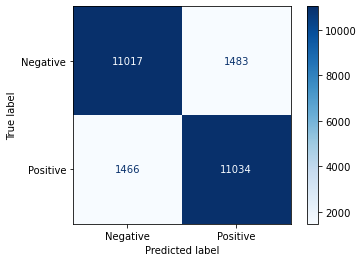

In [111]:
plot_confusion_matrix(
    best_model,
    X_test,
    y_test,
    display_labels=["Negative", "Positive"],
    values_format="d",
    cmap=plt.cm.Blues,
)

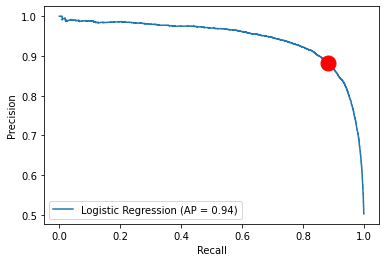

In [112]:
plot_precision_recall_curve(best_model, X_test, y_test, name="Logistic Regression")
plt.plot(
    recall_score(y_test, best_model.predict(X_test)),
    precision_score(y_test, best_model.predict(X_test)),
    "or",
    markersize=15,
)

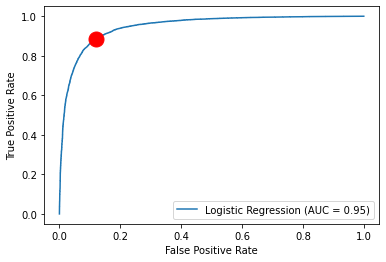

In [113]:
rc = plot_roc_curve(best_model, X_test, y_test, name='Logistic Regression');
plt.plot(cm[0,1]/(cm[0].sum()), cm[1,1]/(cm[1].sum()), 'or', markersize=15);

- The goodness of PR curve is 0.94 which means the threshold of 0.5 is good enough to separate positive and negatives reviews.
- The goodness of ROC curve is 0.95 which means our prediction is way better than a random guesser. Also, the result is consistent than AP.
- Since both positive and negative classes are important to us and our dataset is balanced, the confusion matrix shows a good spread of true positives and false negatives which is consistent to the test accuracy we get.

## Some insights and further improvements

### Examine the misclassified examples from test set

In [114]:
preds = best_model.predict(X_test)
misclassified = np.where(y_test != preds)[0]
X_test[misclassified]

4        Brass pictures (movies is not a fitting word f...
16       At the bottom end of the apocalypse movie scal...
17       Earth has been destroyed in a nuclear holocaus...
44       This tale of the upper-classes getting their c...
48       While the premise of the film sounded unique a...
                               ...                        
24936    I've noticed that a lot of people are taking O...
24947    People have often been uncomfortable with "The...
24958    The Merchant of Venice 8/10<br /><br />(This r...
24972    When i first saw the movie being advertised i ...
24977    This is not a movie that I would typically wat...
Name: review, Length: 2949, dtype: object

**Notes:** 
- By inspecting the dataset, I found some of them does not express any attitudes towards the movie, instead, they probably talk about some facts or thoughts from the movie which is neutral. Therefore, the probability of predicting those reviews to positive might be close to the threshold and make them hard to differentiate between classes. 
- There are also some garbage reviews which should be excluded from dataset but we probably need human labor to do that.
- The best model seems to work fairly well when there are clear words indicating whether the review is positive or negative, as the features we are using are word features. However the models fails for more complex examples, where understanding the context and overall text is essential to correctly classify reviews. These example demonstrates the limitations of bag of word models. 
- We need to incorporate deeper linguistic knowledge to correctly classify such cases such as seq-to-seq models, LSTM and BERT.